In [1]:
"""
FEniCS tutorial demo program: Incompressible Navier-Stokes equations
for flow around a cylinder using the Incremental Pressure Correction
Scheme (IPCS).
  u' + u . nabla(u)) - div(sigma(u, p)) = f
                                 div(u) = 0
"""

from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np

In [2]:
T = 5.0            # final time
num_steps = 5000   # number of time steps
dt = T / num_steps # time step size
mu = 0.001         # dynamic viscosity
rho = 1            # density

In [3]:
# Create mesh
channel = Rectangle(Point(0, 0), Point(2.2, 0.41))
cylinder = Circle(Point(0.2, 0.2), 0.05)
domain = channel - cylinder
mesh = generate_mesh(domain, 64)

In [4]:
# Define function spaces
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

In [5]:
# Define boundaries
inflow   = 'near(x[0], 0)'
outflow  = 'near(x[0], 2.2)'
walls    = 'near(x[1], 0) || near(x[1], 0.41)'
cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'

In [7]:
# Define inflow profile
inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

# Define boundary conditions
bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
bcp = [bcp_outflow]

In [8]:
# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

In [9]:
# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

In [10]:
# Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

In [11]:
# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

In [12]:
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx \
   + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

In [13]:
# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[None]

In [14]:
# Create XDMF files for visualization output
xdmffile_u = XDMFFile('navier_stokes_cylinder/velocity.xdmf')
xdmffile_p = XDMFFile('navier_stokes_cylinder/pressure.xdmf')

In [15]:
# Create time series (for use in reaction_system.py)
timeseries_u = TimeSeries('navier_stokes_cylinder/velocity_series')
timeseries_p = TimeSeries('navier_stokes_cylinder/pressure_series')


In [16]:
# Save mesh to file (for use in reaction_system.py)
File('navier_stokes_cylinder/cylinder.xml.gz') << mesh

In [22]:
# Create progress bar
progress = Progress("Looping", num_steps)
set_log_level(LogLevel.PROGRESS)

u max: 2.3464290141232067
u max: 2.3007818040787207
u max: 2.2423722757128637
u max: 2.2112930630804413
u max: 2.2041650359059757
u max: 2.177777351151647
u max: 2.1385513899307242
u max: 2.0924466533977166
u max: 2.0444494860362665
u max: 1.9984657727111053
u max: 1.957272998729291
u max: 1.9729039513861224
u max: 1.9870920979137923
u max: 1.9968313882642967
u max: 2.002679514796766
u max: 2.0052827734914445
u max: 2.0053313593600386
u max: 2.0035123435597546
u max: 2.0004609703719045
u max: 1.9967185825725238
u max: 1.992705282858598
u max: 1.988710746932778
u max: 1.9849017476738564
u max: 1.9813420310323846
u max: 1.978019250011505
u max: 1.974873973157631
u max: 1.971826689929726
u max: 1.9687998958814052
u max: 1.9657335941185292
u max: 1.9625937674139242
u max: 1.9593744174308112
u max: 1.9560945119697686
u max: 1.9527915665120632
u max: 1.9495136270277476
u max: 1.946311192919075
u max: 1.9432302285493726
u max: 1.9403069650016693
u max: 1.9375647744979714
u max: 1.935013061333

u max: 2.1797659150291677
u max: 2.1797638090829383
u max: 2.17976173065658
u max: 2.179759823822553
u max: 2.1797583033653494
u max: 2.1797574164958577
u max: 2.1797574019831734
u max: 2.179758453029614
u max: 2.179760689287932
u max: 2.17976414173336
u max: 2.1797687519527513
u max: 2.179774385146364
u max: 2.1797808541007084
u max: 2.179787949875729
u max: 2.179795474155545
u max: 2.17980326821969
u max: 2.1798112342591884
u max: 2.179819346135578
u max: 2.1798276484259773
u max: 2.1798362444345463
u max: 2.1798452755014486
u max: 2.1798548951660606
u max: 2.1798652423775127
u max: 2.1798764179225434
u max: 2.1798884675888326
u max: 2.179901374423616
u max: 2.1799150609752513
u max: 2.179929400850877
u max: 2.1799442375219504
u max: 2.179959407266235
u max: 2.1799747625945347
u max: 2.179990192539204
u max: 2.1800056367588416
u max: 2.1800210914377196
u max: 2.1800366062638985
u max: 2.180052273152817
u max: 2.1800682086326204
u max: 2.18008453273738
u max: 2.180101347730136
u max: 

u max: 2.1387368992895164
u max: 2.138593565879992
u max: 2.1384541745049512
u max: 2.1383187635760543
u max: 2.1381873706761216
u max: 2.138060032667771
u max: 2.13793678577177
u max: 2.1378176655999974
u max: 2.1377027071359693
u max: 2.1375919446648886
u max: 2.137485411663789
u max: 2.137383140668872
u max: 2.1372851631406506
u max: 2.137191509347425
u max: 2.1371022082839994
u max: 2.1370172876361693
u max: 2.136936773793492
u max: 2.136860691904554
u max: 2.136789065962054
u max: 2.136721918900296
u max: 2.1366592726862343
u max: 2.136601148387008
u max: 2.136547566201494
u max: 2.1364985454500696
u max: 2.1364541045241814
u max: 2.1364142608040817
u max: 2.1363790305583628
u max: 2.136348428841453
u max: 2.1363224694049934
u max: 2.1363011646361296
u max: 2.136284525530557
u max: 2.1362725617019978
u max: 2.136265281423575
u max: 2.136262691691313
u max: 2.136264798296803
u max: 2.136271605895121
u max: 2.1362831180556467
u max: 2.136299337287036
u max: 2.136320265032478
u max: 

u max: 2.1441450680367726
u max: 2.1437550774914897
u max: 2.1433664125261225
u max: 2.1429792022893515
u max: 2.1425935760925343
u max: 2.1422096633694383
u max: 2.1418275936355884
u max: 2.141447496447255
u max: 2.1410695013600294
u max: 2.1406937378870476
u max: 2.1403203354568543
u max: 2.1399494233709864
u max: 2.1395811307613073
u max: 2.1392155865471882
u max: 2.138852919392512
u max: 2.138493257662611
u max: 2.1381367293810825
u max: 2.1377834621865186
u max: 2.137433583289104
u max: 2.137087219427089
u max: 2.1367444968230918
u max: 2.136405541140246
u max: 2.1360704774381745
u max: 2.1357394301288304
u max: 2.1354125229321963
u max: 2.1350898788319497
u max: 2.134771620031072
u max: 2.1344578679074493
u max: 2.134148742969524
u max: 2.1338443648119827
u max: 2.13354485207147
u max: 2.133250322382357
u max: 2.1329608923325116
u max: 2.132676677419079
u max: 2.1323977920042503
u max: 2.132124349271041
u max: 2.1318564611790882
u max: 2.1315942384205058
u max: 2.131337790375828


u max: 2.1770883165635944
u max: 2.176476531195094
u max: 2.175859287159039
u max: 2.175236795050966
u max: 2.174609268490833
u max: 2.173976924073728
u max: 2.173339981321035
u max: 2.1726986626317126
u max: 2.172053193233187
u max: 2.171403801131296
u max: 2.1707507170588016
u max: 2.1700941744219397
u max: 2.1694344092445865
u max: 2.1687716601097207
u max: 2.1681061680979656
u max: 2.167438176723096
u max: 2.1667679318644706
u max: 2.166095681696495
u max: 2.1654216766152543
u max: 2.1647461691624637
u max: 2.1640694139470478
u max: 2.1633916675645235
u max: 2.1627131885145374
u max: 2.162034237116746
u max: 2.1613550754253357
u max: 2.1606759671423506
u max: 2.1599971775300175
u max: 2.159318973322123
u max: 2.158641622634467
u max: 2.157965394874284
u max: 2.15729056064847
u max: 2.1566173916703035
u max: 2.1559461606643486
u max: 2.1552771412691016
u max: 2.1546106079369602
u max: 2.1539468358310803
u max: 2.153286100718741
u max: 2.1526286788609204
u max: 2.1519748468978714
u m

u max: 2.220682682974573
u max: 2.2198238435397357
u max: 2.218952392060003
u max: 2.2180686322390195
u max: 2.2171728737756613
u max: 2.2162654323002893
u max: 2.215346629309749
u max: 2.214416792100159
u max: 2.2134762536965096
u max: 2.212525352778376
u max: 2.211564433601151
u max: 2.210593845912516
u max: 2.209613944864119
u max: 2.208625090918693
u max: 2.2076276497530882
u max: 2.2066219921579306
u max: 2.2056084939346965
u max: 2.204587535791099
u max: 2.2035595032355046
u max: 2.202524786470919
u max: 2.201483780288679
u max: 2.2004368839616157
u max: 2.1993845011358832
u max: 2.198327039720237
u max: 2.1972649117711787
u max: 2.1961985333721303
u max: 2.195128324504774
u max: 2.194054708910921
u max: 2.192978113943651
u max: 2.1918989704071294
u max: 2.1908177123852095
u max: 2.1897347770597944
u max: 2.1886506045205634
u max: 2.187565637568388
u max: 2.1864803215149737
u max: 2.185395103981418
u max: 2.1843104346980504
u max: 2.1832267653073547
u max: 2.182144549170953
u max

u max: 2.2513159285203153
u max: 2.2502442439509576
u max: 2.2491544966337886
u max: 2.248047049699986
u max: 2.246922274707344
u max: 2.2457805515814107
u max: 2.244622268545785
u max: 2.24344782203978
u max: 2.2422576166239514
u max: 2.24105206487584
u max: 2.239831587279352
u max: 2.238596612111411
u max: 2.237347575328829
u max: 2.236084920457085
u max: 2.2348090984813087
u max: 2.2335205677384335
u max: 2.2322197938086443
u max: 2.230907249403963
u max: 2.2295834142519033
u max: 2.2282487749725775
u max: 2.2269038249480664
u max: 2.2255490641831472
u max: 2.2241849991566407
u max: 2.222812142662622
u max: 2.2214310136408355
u max: 2.220042136995912
u max: 2.218646043405595
u max: 2.217243269118977
u max: 2.2158343557467814
u max: 2.214419850046525
u max: 2.2130003037058277
u max: 2.211576273127136
u max: 2.2101483192162537
u max: 2.208717007175995
u max: 2.2072829063045725
u max: 2.205846589796877
u max: 2.2044086345454024
u max: 2.2029696209368193
u max: 2.201530132640079
u max: 

u max: 2.2754696493485156
u max: 2.2743107146634163
u max: 2.273128622462599
u max: 2.2719237525731617
u max: 2.2706964952587314
u max: 2.269447251152815
u max: 2.2681764311888224
u max: 2.2668844565226505
u max: 2.2655717584452204
u max: 2.264238778284191
u max: 2.2628859672956967
u max: 2.2615137865481403
u max: 2.260122706800187
u max: 2.2587132083747927
u max: 2.257285781030122
u max: 2.2558409238275083
u max: 2.2543791449959656
u max: 2.2529009617930087
u max: 2.251406900361824
u max: 2.2498974955856084
u max: 2.2483732909400196
u max: 2.246834838344554
u max: 2.245282698012697
u max: 2.243717438299275
u max: 2.2421396355421335
u max: 2.240549873894252
u max: 2.23894874514236
u max: 2.237336848509054
u max: 2.2357147904371413
u max: 2.2340831843573357
u max: 2.2324426504425166
u max: 2.230793815353469
u max: 2.2291373119816673
u max: 2.227473779194249
u max: 2.2258038615850317
u max: 2.2241282092334416
u max: 2.222447477471092
u max: 2.2207623266539067
u max: 2.2190734219362307
u 

u max: 2.2940535962993245
u max: 2.292938397218554
u max: 2.2917957864494523
u max: 2.2906261139038455
u max: 2.2894297413817224
u max: 2.2882070425373087
u max: 2.286958402832691
u max: 2.2856842194761353
u max: 2.284384901343665
u max: 2.283060868884181
u max: 2.2817125540105345
u max: 2.2803403999804823
u max: 2.2789448612722767
u max: 2.277526403459202
u max: 2.2760855030859024
u max: 2.274622647547163
u max: 2.27313833496747
u max: 2.271633074077999
u max: 2.2701073840870705
u max: 2.2685617945407044
u max: 2.2669968451718243
u max: 2.265413085738693
u max: 2.2638110758554455
u max: 2.262191384818663
u max: 2.260554591434122
u max: 2.258901283846677
u max: 2.2572320593742248
u max: 2.255547524344588
u max: 2.253848293932008
u max: 2.252134991988724
u max: 2.250408250866773
u max: 2.2486687112256307
u max: 2.2469170218226155
u max: 2.2451538392846624
u max: 2.243379827861897
u max: 2.241595659165065
u max: 2.239802011890284
u max: 2.2379995715353735
u max: 2.2361890301124596
u max:

u max: 2.3073463821370654
u max: 2.3063667725670904
u max: 2.305356532868134
u max: 2.3043159527376944
u max: 2.303245334165689
u max: 2.3021449914642425
u max: 2.301015251302512
u max: 2.2998564527428087
u max: 2.29866894727258
u max: 2.2974530988256907
u max: 2.2962092837864456
u max: 2.294937890971008
u max: 2.2936393215830186
u max: 2.2923139891430777
u max: 2.2909623193948008
u max: 2.289584750192472
u max: 2.2881817313768553
u max: 2.2867537246455583
u max: 2.2853012034229785
u max: 2.2838246527324664
u max: 2.282324569070395
u max: 2.28080146027947
u max: 2.2792558454170484
u max: 2.277688254614145
u max: 2.276099228922118
u max: 2.274489320146127
u max: 2.2728590906669313
u max: 2.2712091132547823
u max: 2.2695399708802806
u max: 2.2678522565271573
u max: 2.2661465730109387
u max: 2.264423532805572
u max: 2.262683757877943
u max: 2.2609278795279635
u max: 2.259156538230042
u max: 2.257370383470489
u max: 2.2555700735747837
u max: 2.2537562755188216
u max: 2.2519296647192983
u m

u max: 2.31732562732461
u max: 2.316568039991872
u max: 2.3157773425554753
u max: 2.3149537386495482
u max: 2.3140974443134956
u max: 2.3132086879965463
u max: 2.312287710554124
u max: 2.3113347652414986
u max: 2.3103501177104544
u max: 2.309334046014269
u max: 2.308286840624801
u max: 2.3072088044635097
u max: 2.306100252945484
u max: 2.304961514032752
u max: 2.3037929282908305
u max: 2.302594848940629
u max: 2.3013676418974236
u max: 2.3001116857893154
u max: 2.298827371949635
u max: 2.2975151043807354
u max: 2.2961752996897746
u max: 2.2948083870002725
u max: 2.2934148078452243
u max: 2.291995016048397
u max: 2.2905494775997814
u max: 2.2890786705293436
u max: 2.2875830847805205
u max: 2.2860632220823924
u max: 2.2845195958174114
u max: 2.282952730880692
u max: 2.28136316352745
u max: 2.2797514412065967
u max: 2.278118122380826
u max: 2.2764637763357722
u max: 2.274788982982586
u max: 2.273094332659197
u max: 2.2713804259354062
u max: 2.269647873425977
u max: 2.2678972956141368
u ma

u max: 2.323306319875565
u max: 2.322767642851929
u max: 2.322194464705063
u max: 2.3215869094623227
u max: 2.3209451133345804
u max: 2.3202692248206676
u max: 2.3195594047946377
u max: 2.3188158265735836
u max: 2.3180386759648517
u max: 2.3172281512929986
u max: 2.3163844634085544
u max: 2.3155078356823413
u max: 2.314598503990662
u max: 2.313656716697701
u max: 2.3126827346417556
u max: 2.311676831131461
u max: 2.31063929195658
u max: 2.3095704154158025
u max: 2.308470512360979
u max: 2.307339906254332
u max: 2.306178933232382
u max: 2.3049879421684705
u max: 2.3037672947249654
u max: 2.3025173653868682
u max: 2.301238541470471
u max: 2.299931223103499
u max: 2.298595823176637
u max: 2.2972327672692754
u max: 2.2958424935547055
u max: 2.2944254526910113
u max: 2.29298210770347
u max: 2.2915129338627276
u max: 2.2900184185605923
u max: 2.2884990611828635
u max: 2.286955372976585
u max: 2.285387876908192
u max: 2.2837971075093306
u max: 2.2821836107084117
u max: 2.2805479436480707
u ma

u max: 2.327163912955539
u max: 2.326892932822176
u max: 2.3265867201682564
u max: 2.3262453097373648
u max: 2.325868747462043
u max: 2.325457090605968
u max: 2.325010407911878
u max: 2.3245287797521508
u max: 2.32401229827901
u max: 2.3234610675711727
u max: 2.322875203773548
u max: 2.322254835226377
u max: 2.321600102580227
u max: 2.320911158893422
u max: 2.3201881697092253
u max: 2.3194313131110773
u max: 2.3186407797557105
u max: 2.3178167728856693
u max: 2.3169595083246275
u max: 2.3160692144605193
u max: 2.315146132222873
u max: 2.3141905150613375
u max: 2.313202628932235
u max: 2.312182752298851
u max: 2.311131176149194
u max: 2.3100482040321926
u max: 2.308934152110212
u max: 2.3077893492228374
u max: 2.3066141369543933
u max: 2.305408869696309
u max: 2.3041739146954425
u max: 2.302909652080728
u max: 2.301616474863005
u max: 2.3002947889060543
u max: 2.2989450128701057
u max: 2.2975675781318423
u max: 2.296162928686506
u max: 2.2947315210380697
u max: 2.293273824082367
u max: 

u max: 2.3284852266338483
u max: 2.3284518810515826
u max: 2.3283832718672826
u max: 2.328279361055561
u max: 2.328140121206236
u max: 2.3279655355566455
u max: 2.3277555980460196
u max: 2.3275103133912842
u max: 2.327229697182681
u max: 2.3269137759968186
u max: 2.3265625875242497
u max: 2.3261761807084107
u max: 2.3257546158927633
u max: 2.325297964972977
u max: 2.3248063115509043
u max: 2.324279751087151
u max: 2.3237183910486525
u max: 2.3231223510476138
u max: 2.3224917629679807
u max: 2.321826771075669
u max: 2.321127532109337
u max: 2.320394215349291
u max: 2.3196270026634065
u max: 2.3188260885306238
u max: 2.317991680044411
u max: 2.317123996900369
u max: 2.3162232713738073
u max: 2.3152897482941475
u max: 2.314323685023352
u max: 2.3133253514451106
u max: 2.3122950299698823
u max: 2.311233015558715
u max: 2.3101396157656886
u max: 2.309015150795749
u max: 2.307859953571811
u max: 2.30667436980296
u max: 2.3054587580445878
u max: 2.304213489741873
u max: 2.3029389492496373
u m

u max: 2.3279852497580023
u max: 2.32818867688484
u max: 2.328357339082951
u max: 2.3284911260640775
u max: 2.3285899383400297
u max: 2.3286536871813825
u max: 2.328682294572048
u max: 2.3286756931662986
u max: 2.3286338262541455
u max: 2.328556647740121
u max: 2.328444122139441
u max: 2.3282962245944705
u max: 2.328112940912981
u max: 2.327894267628592
u max: 2.3276402120824913
u max: 2.327350792524612
u max: 2.327026038231684
u max: 2.3266659896392112
u max: 2.326270698484153
u max: 2.3258402279551382
u max: 2.325374652846945
u max: 2.3248740597159783
u max: 2.3243385470332805
u max: 2.3237682253313965
u max: 2.3231632173412837
u max: 2.322523658115275
u max: 2.321849695132462
u max: 2.3211414883833665
u max: 2.3203992104318787
u max: 2.319623046453856
u max: 2.318813194253514
u max: 2.317969864260605
u max: 2.317093279513208
u max: 2.316183675632408
u max: 2.315241300795946
u max: 2.3142664157181585
u max: 2.3132592936425227
u max: 2.3122202203514637
u max: 2.3111494941954738
u max:

u max: 2.3257961095631967
u max: 2.326231267050495
u max: 2.326632672120805
u max: 2.327000141715794
u max: 2.32733350331401
u max: 2.327632595050398
u max: 2.327897265808552
u max: 2.3281273752827096
u max: 2.328322794009594
u max: 2.328483403372853
u max: 2.3286090955850893
u max: 2.3286997736537427
u max: 2.3287553513376924
u max: 2.3287757531014943
u max: 2.3287609140736456
u max: 2.328710780014567
u max: 2.3286253072991925
u max: 2.3285044629177873
u max: 2.3283482244976597
u max: 2.3281565803469357
u max: 2.3279295295205134
u max: 2.3276670819069802
u max: 2.327369258334522
u max: 2.3270360906931313
u max: 2.326667622070013
u max: 2.326263906895057
u max: 2.3258250110930705
u max: 2.3253510122395444
u max: 2.32484199971656
u max: 2.324298074865311
u max: 2.3237193511314285
u max: 2.323105954199183
u max: 2.322458022110647
u max: 2.3217757053661794
u max: 2.32105916700338
u max: 2.320308582652839
u max: 2.3195241405704703
u max: 2.318706041648128
u max: 2.317854499406014
u max: 2.

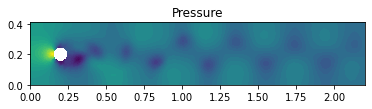

In [25]:
# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3, 'cg', 'sor')

    # Plot solution
    plot(u_, title='Velocity')
    plot(p_, title='Pressure')

    # Save solution to file (XDMF/HDF5)
    xdmffile_u.write(u_, t)
    xdmffile_p.write(p_, t)

    # Save nodal values to file
    timeseries_u.store(u_.vector(), t)
    timeseries_p.store(p_.vector(), t)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)

    # Update progress bar
    #progress(t / T)
    progress += 1
    print('u max:', u_.vector().get_local().max())

In [ ]:
# Hold plot
interactive()